<h2> Обработка </h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

samsa = pd.read_csv('Netflix_Historical_StockPrice2.csv')
samsa.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,98.339996,101.440002,97.820000,101.209999,101.209999,12432200
1,2016-03-29,101.080002,104.330002,101.000000,104.129997,104.129997,16008900
2,2016-03-30,104.650002,104.910004,101.480003,102.190002,102.190002,14705000
3,2016-03-31,102.430000,103.529999,101.050003,102.230003,102.230003,9747500
4,2016-04-01,102.930000,105.790001,102.470001,105.699997,105.699997,14182400
5,2016-04-04,105.900002,105.919998,103.199997,104.349998,104.349998,10940400
6,2016-04-05,103.470001,105.750000,103.250000,104.940002,104.940002,10060900
7,2016-04-06,105.300003,106.440002,104.250000,104.830002,104.830002,9605800
8,2016-04-07,104.309998,106.440002,103.599998,104.449997,104.449997,10774900
9,2016-04-08,105.120003,105.330002,102.820000,103.809998,103.809998,7857600


In [2]:
samsa.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<h3> Группируем по месяцам </h3>

In [3]:
samsa['Date'] = pd.to_datetime(samsa['Date'], format='%Y-%m-%d')
samsa = samsa.groupby(pd.Grouper(key='Date',freq='M')).mean()
samsa.drop(['Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)
samsa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2016-03-31 to 2021-03-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    61 non-null     float64
 1   High    61 non-null     float64
dtypes: float64(2)
memory usage: 1.4 KB


<h4> Преобразование с дней в месяцы (собственная чересчур большая) </h4>
from datetime import datetime

samsa1 = pd.DataFrame(columns=['Date', 'High'])

last_month = 0
for value in samsa.itertuples():
    if (value.Date.month != last_month):
        last_month = value.Date.month
        samsa1 = samsa1.append({'Date': datetime.date(value.Date),
                        'High': value.High}, ignore_index=True)
samsa = samsa1
samsa = samsa.set_index('Date')
samsa.head(20)


<AxesSubplot: title={'center': 'Stocks by months'}, xlabel='Date', ylabel='Price'>

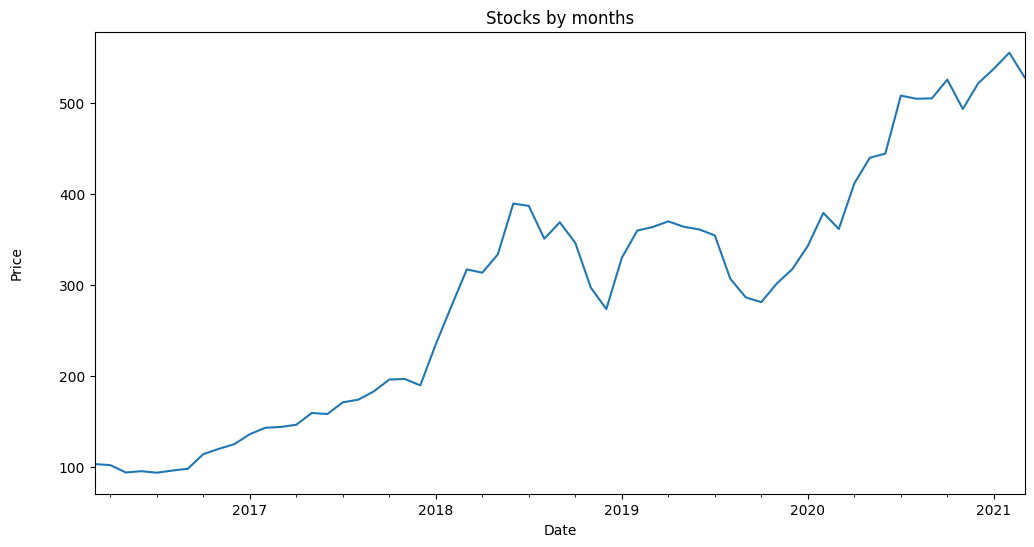

In [4]:
plt.figure(figsize=(12, 6))
plt.title('Stocks by months')
plt.ylabel('Price', labelpad=25)
samsa['High'].plot()

<h2> Найдем декомпозицию и построим графики сезонов, трендов и остального</h2>

<Figure size 1200x600 with 0 Axes>

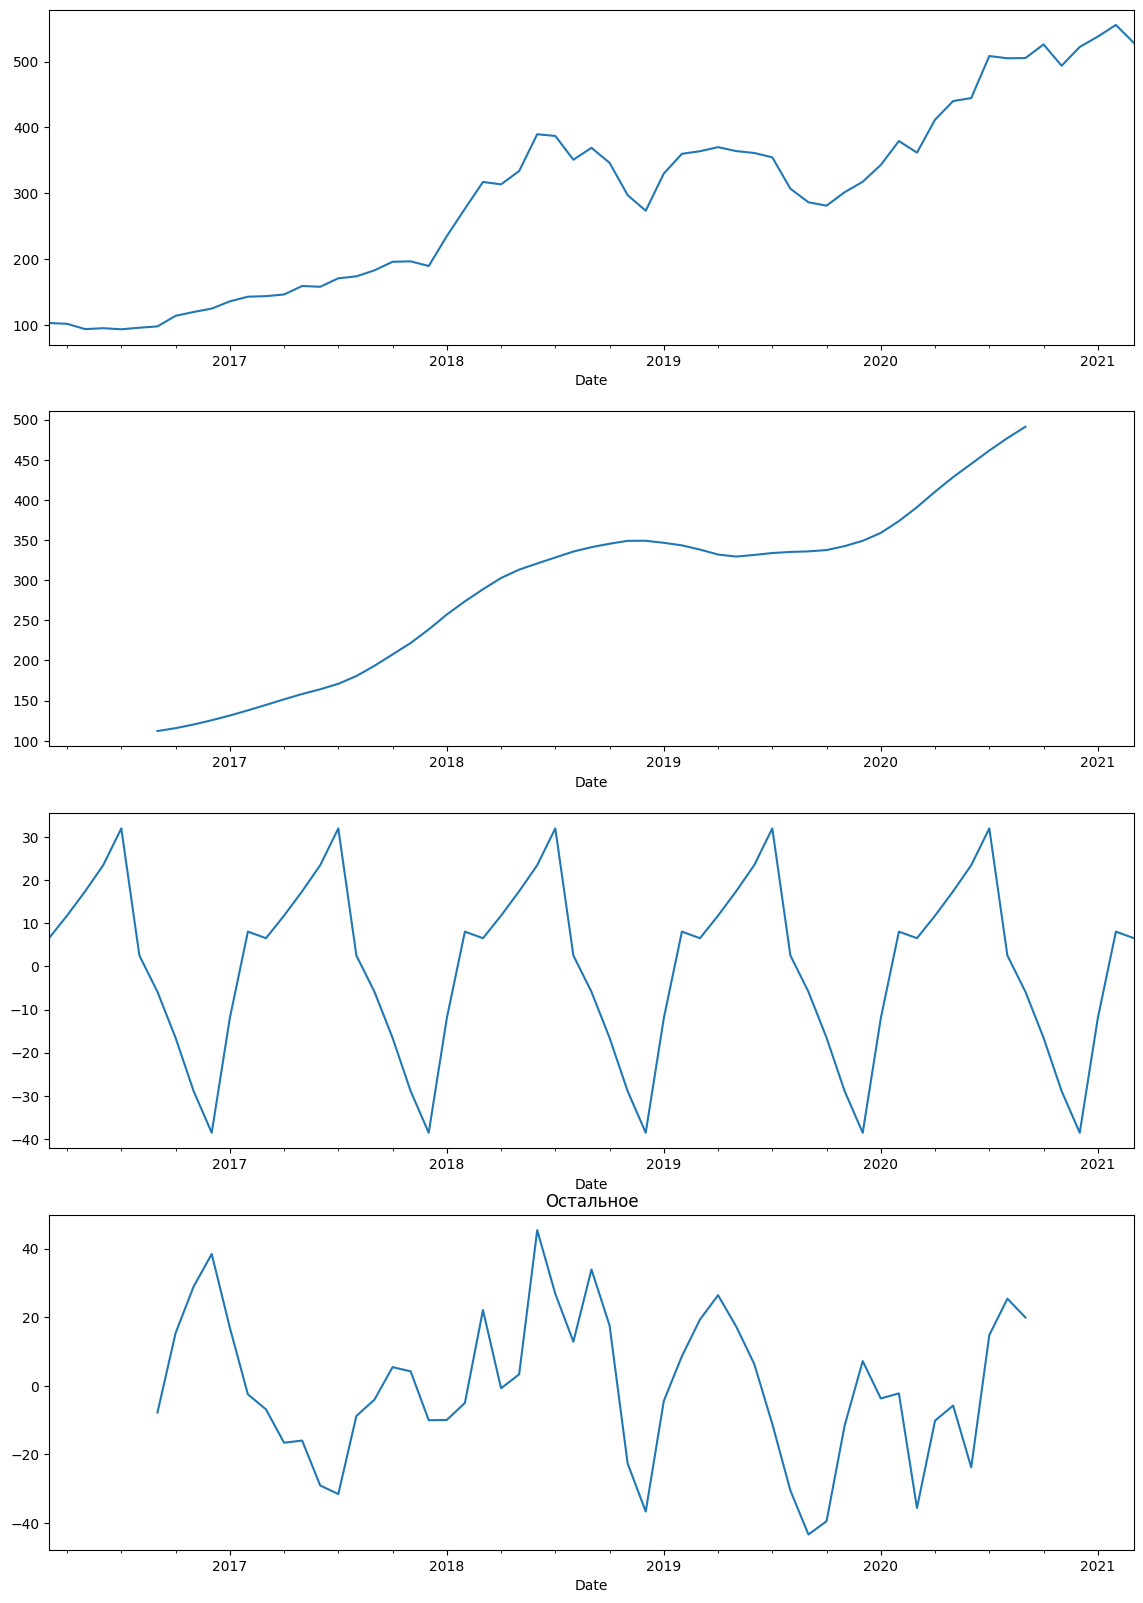

In [5]:
plt.figure(figsize=(12, 6))
decomposition = seasonal_decompose(samsa['High'], period=12)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 20))

plt.title('Обычный')
decomposition.observed.plot(ax=ax[0])

plt.title('Тренды')
decomposition.trend.plot(ax=ax[1])

plt.title('Сезоны')
decomposition.seasonal.plot(ax=ax[2])

plt.title('Остальное')
decomposition.resid.plot(ax=ax[3]);

<h3>Пытаемся пройти тест Дики-Фуллера</h3>

In [6]:
p_value = adfuller(samsa['High'])[1]
print(f'Полученный уровень значимости (p-value): {p_value}')

if round(p_value, 4) > 0.05:
    print('Принимаем нулевую гипотезу, ряд нестационарен')
else:
    print('Принимаем альтернативную гипотезу, ряд стационарен')


Полученный уровень значимости (p-value): 0.9249789733983723
Принимаем нулевую гипотезу, ряд нестационарен


<h3>Добавим логарифмирование</h3>

In [7]:
samsa['StockLog'] = np.log(samsa['High'])
samsa.head()

,Open,High,StockLog
Date,,,
2016-03-31,101.625000,103.552502,4.640079
2016-04-30,101.054286,102.418572,4.629068
2016-05-31,92.705715,94.337619,4.546880
2016-06-30,94.777273,95.731817,4.561551
2016-07-31,92.782500,94.064499,4.543981


In [8]:
p_value = adfuller(samsa['StockLog'])[1]

print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}')

if round(p_value, 4) > 0.05:
    print('Принимаем нулевую гипотезу, ряд нестационарен')
else:
    print('Принимаем альтернативную гипотезу, ряд стационарен')

Полученный уровень значимости (p-value): 0.6519
Принимаем нулевую гипотезу, ряд нестационарен


<h3> Добавим дифферинцирование</h3>

In [9]:
samsa['StockLogDif'] = samsa['StockLog'].diff(1)
samsa.head()

,Open,High,StockLog,StockLogDif
Date,,,,
2016-03-31,101.625000,103.552502,4.640079,NaN
2016-04-30,101.054286,102.418572,4.629068,-0.011011
2016-05-31,92.705715,94.337619,4.546880,-0.082188
2016-06-30,94.777273,95.731817,4.561551,0.014671
2016-07-31,92.782500,94.064499,4.543981,-0.017570


In [10]:
p_value = adfuller(samsa['StockLogDif'][1:])[1]

print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}')

if round(p_value, 4) > 0.05:
    print('Принимаем нулевую гипотезу, ряд нестационарен')
else:
    print('Принимаем альтернативную гипотезу, ряд стационарен')

Полученный уровень значимости (p-value): 0.0
Принимаем альтернативную гипотезу, ряд стационарен


<AxesSubplot: xlabel='Date'>

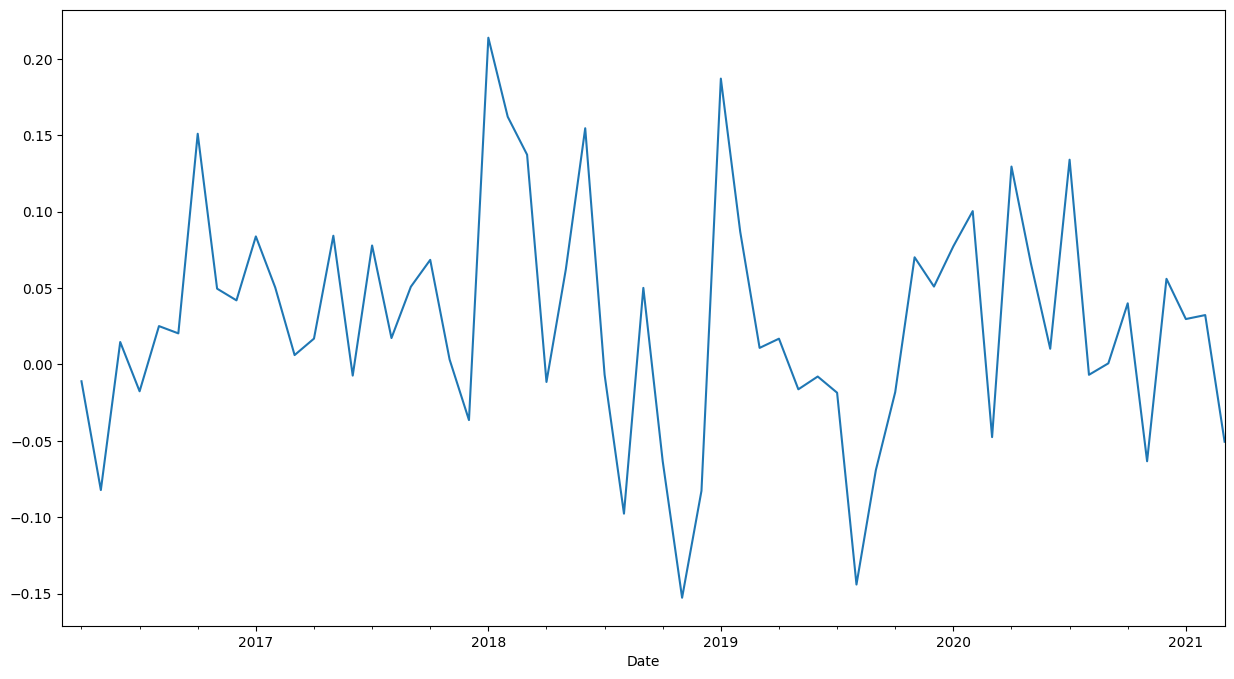

In [11]:
plt.figure(figsize=(15, 8))
samsa['StockLogDif'].plot()

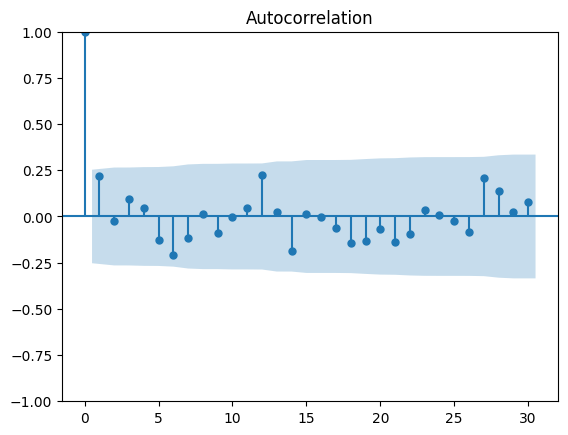

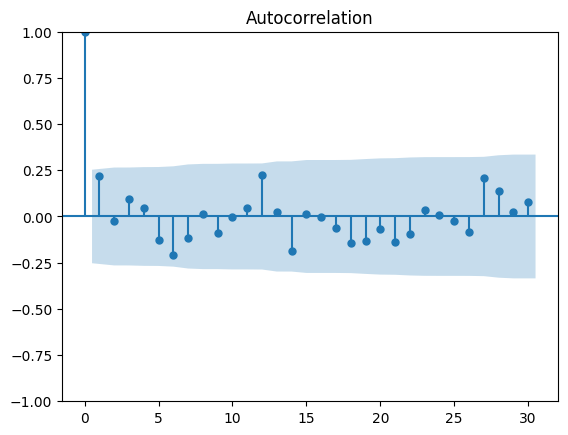

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(samsa['StockLogDif'][1:], lags=30)

Распределение выглядит тоже нормально

(array([1.36442139, 0.        , 2.04663209, 2.04663209, 2.04663209,
        6.82210697, 6.13989628, 4.09326418, 5.45768558, 4.77547488,
        0.6822107 , 2.04663209, 2.04663209, 0.6822107 , 0.6822107 ]),
 array([-0.15265918, -0.1282288 , -0.10379842, -0.07936804, -0.05493766,
        -0.03050728, -0.0060769 ,  0.01835348,  0.04278386,  0.06721424,
         0.09164462,  0.116075  ,  0.14050538,  0.16493576,  0.18936615,
         0.21379653]),
 <BarContainer object of 15 artists>)

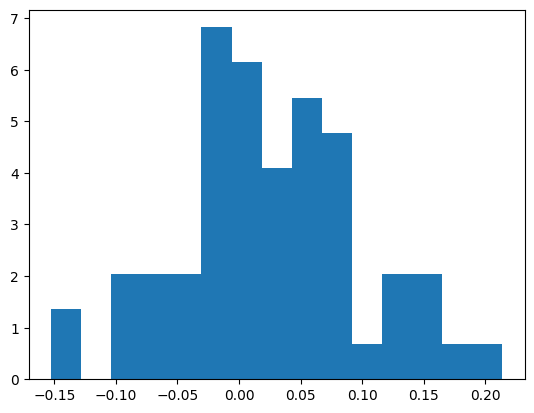

In [13]:
plt.hist(samsa['StockLogDif'], density=True, bins=15)

<h2>Обучение</h2>

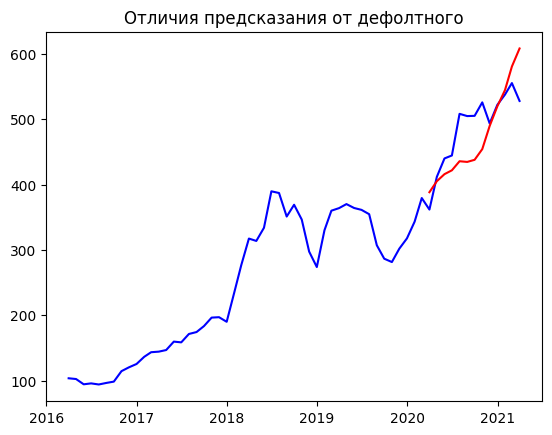

In [14]:
from pmdarima.arima import auto_arima
from pmdarima import model_selection
train, test = model_selection.train_test_split(samsa['High'], train_size=0.8)
model = auto_arima(np.log(train), test='adf',
                   seasonal=True, stepwise=True, suppress_warnings=True, m=12,
                   error_action='ignore')
predicted = model.predict(n_periods=test.shape[0], return_conf_int=False)
plt.plot(samsa['High'], 'b', np.exp(predicted), 'r')
plt.title('Отличия предсказания от дефолтного')
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(test, np.exp(predicted))

0.07451463770735894